Project Scope & Functional Objectives for Smart Energy Analysis

1. Project Scope

The scope of this project is to design and develop an intelligent Smart Energy Consumption Analysis System capable of monitoring, analyzing, and predicting electricity usage at a device level within a smart home environment.
The system uses timestamped sensor data to extract meaningful insights about consumption behavior and applies machine learning models (Linear Regression and LSTM) to forecast future energy usage.

Collect and Structure the SmartHome Energy Monitoring Dataset

dataset:-"C:\Users\gangu\Downloads\smarthome_energy_6months.csv"

2. Load and Structure the Dataset (Code)

In [47]:
import pandas as pd

# Load dataset
df = pd.read_csv(r"C:\Users\gangu\Downloads\smarthome_energy_6months.csv",parse_dates=["timestamp"])

# Sort by timestamp for proper time-series order
df = df.sort_values("timestamp")

# Display dataset structure
print("Dataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())

# Show first few rows
df.head()


Dataset shape: (628992, 4)

Columns: ['timestamp', 'device_name', 'room', 'power_watts']


,timestamp,device_name,room,power_watts
0,2024-01-01,Refrigerator,Kitchen,152
11,2024-01-01,Router,Living Room,9
10,2024-01-01,Induction Stove,Kitchen,1042
9,2024-01-01,Water Pump,Outdoor,442
7,2024-01-01,Microwave,Kitchen,783


In [15]:
import pandas as pd

df = pd.read_csv(r"C:\Users\gangu\Downloads\archive (1)\Energy_consumption.csv")
print(df)
print(df.columns)



               Timestamp  Temperature   Humidity  SquareFootage  Occupancy  \
0    2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
1    2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2    2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
3    2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   
4    2022-01-01 04:00:00    23.097359  51.401421    1094.130359          9   
..                   ...          ...        ...            ...        ...   
995  2022-02-11 11:00:00    28.619382  48.850160    1080.087000          5   
996  2022-02-11 12:00:00    23.836647  47.256435    1705.235156          4   
997  2022-02-11 13:00:00    23.005340  48.720501    1320.285281          6   
998  2022-02-11 14:00:00    25.138365  31.306459    1309.079719          3   
999  2022-02-11 15:00:00    23.051165  42.615421    1018.140606          6   

    HVACUsage LightingUsage  RenewableEnergy  DayOfWeek Holiday

3.Organize the Data by Device, Room, and Timestamp

In [52]:
# Group the dataset by device and timestamp (5-min intervals)
device_grouped = df.groupby(["device_name", "timestamp"])["power_watts"].sum().reset_index()

# Add room-level segmentation
room_grouped = df.groupby(["room", "timestamp"])["power_watts"].sum().reset_index()

print("Device-level structure:")
display(device_grouped.head())

print("Room-level structure:")
display(room_grouped.head())


Device-level structure:


,device_name,timestamp,power_watts
0,AC,2024-01-01 00:00:00,1237
1,AC,2024-01-01 00:05:00,1020
2,AC,2024-01-01 00:10:00,705
3,AC,2024-01-01 00:15:00,1031
4,AC,2024-01-01 00:20:00,1078


Room-level structure:


,room,timestamp,power_watts
0,Bedroom,2024-01-01 00:00:00,138
1,Bedroom,2024-01-01 00:05:00,141
2,Bedroom,2024-01-01 00:10:00,155
3,Bedroom,2024-01-01 00:15:00,135
4,Bedroom,2024-01-01 00:20:00,149


4. Create a Time-Series Ready Structure

In [58]:
hourly_df = (
    df.set_index("timestamp")
      .groupby("device_name")["power_watts"]
      .resample("h")
      .sum()
      .reset_index()
)

hourly_df.head()


,device_name,timestamp,power_watts
0,AC,2024-01-01 00:00:00,11640
1,AC,2024-01-01 01:00:00,11784
2,AC,2024-01-01 02:00:00,12011
3,AC,2024-01-01 03:00:00,12186
4,AC,2024-01-01 04:00:00,11991


Verify Data Integrity

In [68]:
import pandas as pd
import numpy as np

df = pd.read_csv(r"C:\Users\gangu\Downloads\smarthome_energy_6months.csv", parse_dates=["timestamp"])
df = df.sort_values("timestamp")

print("Dataset shape:", df.shape)
print("\nData Types:")
print(df.dtypes)

# Missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Duplicate rows
duplicate_count = df.duplicated().sum()
print("\nDuplicate Rows:", duplicate_count)

# Negative or impossible power readings
invalid_power = (df["power_watts"] < 0).sum()
print("Invalid (negative) power readings:", invalid_power)


Dataset shape: (628992, 4)

Data Types:
timestamp      datetime64[ns]
device_name            object
room                   object
power_watts             int64
dtype: object

Missing Values:
timestamp      0
device_name    0
room           0
power_watts    0
dtype: int64

Duplicate Rows: 0
Invalid (negative) power readings: 0


Handle Missing Timestamps

Identify missing timestamps for each device

In [74]:
# Check timestamp gaps more than the expected 5 minutes
df = df.sort_values(["device_name", "timestamp"])
df["time_diff"] = df.groupby("device_name")["timestamp"].diff()

missing_ts_report = df[df["time_diff"] > pd.Timedelta("5min")]
print("\nDevices with missing timestamp intervals:")
missing_ts_report.head()



Devices with missing timestamp intervals:


,timestamp,device_name,room,power_watts,time_diff


Reconstruct full timestamp range

In [77]:
full_timestamp_range = pd.date_range(
    start=df["timestamp"].min(),
    end=df["timestamp"].max(),
    freq="5min"
)

print("Expected timestamps:", len(full_timestamp_range))
print("Actual timestamps:", df["timestamp"].nunique())


Expected timestamps: 52416
Actual timestamps: 52416


Fill missing timestamps

In [80]:
# Create full grid for device-wise timestamp completion
devices = df["device_name"].unique()

full_grid = pd.MultiIndex.from_product(
    [devices, full_timestamp_range],
    names=["device_name", "timestamp"]
)

df_full = df.set_index(["device_name", "timestamp"]).reindex(full_grid).reset_index()

# Forward fill missing readings
df_full["power_watts"] = df_full.groupby("device_name")["power_watts"].ffill().fillna(0)

print("New dataset shape after filling:", df_full.shape)
df_full.head()


New dataset shape after filling: (628992, 5)


,device_name,timestamp,room,power_watts,time_diff
0,AC,2024-01-01 00:00:00,Living Room,1237,NaT
1,AC,2024-01-01 00:05:00,Living Room,1020,0 days 00:05:00
2,AC,2024-01-01 00:10:00,Living Room,705,0 days 00:05:00
3,AC,2024-01-01 00:15:00,Living Room,1031,0 days 00:05:00
4,AC,2024-01-01 00:20:00,Living Room,1078,0 days 00:05:00


Exploratory Data Analysis (EDA)

Check distribution and descriptive statistics

In [84]:
print("\nSummary Statistics:")
print(df_full["power_watts"].describe())



Summary Statistics:
count    628992.000000
mean        338.168646
std         428.814104
min           0.000000
25%          40.000000
50%          79.000000
75%         641.000000
max        1706.000000
Name: power_watts, dtype: float64


Device-level statistics

In [87]:
device_stats = df_full.groupby("device_name")["power_watts"].describe()
device_stats


,count,mean,std,min,25%,50%,75%,max
device_name,,,,,,,,
AC,52416.0,999.539110,99.817801,595.0,932.0,1000.0,1067.0,1424.0
Fan,52416.0,49.501355,4.987214,31.0,46.0,50.0,53.0,70.0
Heater,52416.0,8.074424,14.186619,0.0,0.0,0.0,11.0,49.0
Induction Stove,52416.0,1199.850885,120.236551,684.0,1118.0,1200.0,1281.0,1706.0
Laptop,52416.0,59.492121,5.986775,35.0,55.0,60.0,64.0,86.0
Light Bulb,52416.0,14.491777,1.524767,8.0,13.0,14.0,16.0,21.0
Microwave,52416.0,899.831273,90.359790,513.0,839.0,900.0,961.0,1265.0
Refrigerator,52416.0,149.478518,15.047951,76.0,139.0,150.0,160.0,209.0
Router,52416.0,9.500305,1.043808,6.0,9.0,9.0,10.0,14.0


Correlation between devices

In [92]:
hourly = (
    df_full.set_index("timestamp")
           .groupby("device_name")["power_watts"]
           .resample("h")
           .sum()
           .reset_index()
)

pivot_hourly = hourly.pivot(index="timestamp", columns="device_name", values="power_watts").fillna(0)

corr_matrix = pivot_hourly.corr()
corr_matrix


device_name,AC,Fan,Heater,Induction Stove,Laptop,Light Bulb,Microwave,Refrigerator,Router,TV,Washing Machine,Water Pump
device_name,,,,,,,,,,,,
AC,1.000000,-0.013176,0.024686,0.009795,0.023829,-0.012507,-0.022599,0.010063,-0.005642,0.017111,0.011831,-0.001477
Fan,-0.013176,1.000000,0.002653,-0.001039,0.004663,0.009144,-0.018322,-0.026423,-0.003308,0.023787,-0.017916,-0.018384
Heater,0.024686,0.002653,1.000000,0.015476,0.017098,-0.003272,-0.012266,-0.021402,-0.021074,-0.001647,-0.001872,-0.010868
Induction Stove,0.009795,-0.001039,0.015476,1.000000,0.007135,0.014519,-0.024905,0.007624,-0.013973,0.016920,-0.014058,-0.000845
Laptop,0.023829,0.004663,0.017098,0.007135,1.000000,0.001039,-0.013381,0.014696,0.011750,-0.013269,0.001260,0.033116
Light Bulb,-0.012507,0.009144,-0.003272,0.014519,0.001039,1.000000,-0.025265,0.014491,0.000639,0.003064,-0.021471,-0.012800
Microwave,-0.022599,-0.018322,-0.012266,-0.024905,-0.013381,-0.025265,1.000000,-0.009743,0.029806,-0.005263,-0.005137,0.031412
Refrigerator,0.010063,-0.026423,-0.021402,0.007624,0.014696,0.014491,-0.009743,1.000000,0.034383,-0.001182,-0.015067,-0.009967
Router,-0.005642,-0.003308,-0.021074,-0.013973,0.011750,0.000639,0.029806,0.034383,1.000000,-0.009444,-0.003730,-0.009150


Outlier Detection using IQR

In [96]:
iqr_outliers = {}

for device, group in df_full.groupby("device_name"):
    Q1 = group["power_watts"].quantile(0.25)
    Q3 = group["power_watts"].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = group[(group["power_watts"] < lower) | (group["power_watts"] > upper)]

    iqr_outliers[device] = len(outliers)

iqr_outliers


{'AC': 360,
 'Fan': 247,
 'Heater': 7630,
 'Induction Stove': 340,
 'Laptop': 139,
 'Light Bulb': 5,
 'Microwave': 355,
 'Refrigerator': 299,
 'Router': 2449,
 'TV': 272,
 'Washing Machine': 280,
 'Water Pump': 366}

Organize Energy Readings by Device

In [100]:
device_data = (
    df.groupby(["device_name", "timestamp"])["power_watts"]
      .sum()
      .reset_index()
)

print("Device-level structured data:")
device_data.head()


Device-level structured data:


,device_name,timestamp,power_watts
0,AC,2024-01-01 00:00:00,1237
1,AC,2024-01-01 00:05:00,1020
2,AC,2024-01-01 00:10:00,705
3,AC,2024-01-01 00:15:00,1031
4,AC,2024-01-01 00:20:00,1078


Organize Energy Readings by Room

In [104]:
room_data = (
    df.groupby(["room", "timestamp"])["power_watts"]
      .sum()
      .reset_index()
)

print("Room-level structured data:")
room_data.head()


Room-level structured data:


,room,timestamp,power_watts
0,Bedroom,2024-01-01 00:00:00,138
1,Bedroom,2024-01-01 00:05:00,141
2,Bedroom,2024-01-01 00:10:00,155
3,Bedroom,2024-01-01 00:15:00,135
4,Bedroom,2024-01-01 00:20:00,149


Create Time-Series Ready Structure

In [109]:
hourly_data = (
    df.set_index("timestamp")
      .groupby("device_name")["power_watts"]
      .resample("h")
      .sum()
      .reset_index()
)

print("Hourly energy consumption per device:")
hourly_data.head()


Hourly energy consumption per device:


,device_name,timestamp,power_watts
0,AC,2024-01-01 00:00:00,11640
1,AC,2024-01-01 01:00:00,11784
2,AC,2024-01-01 02:00:00,12011
3,AC,2024-01-01 03:00:00,12186
4,AC,2024-01-01 04:00:00,11991


Pivot Table for Dashboard / Visualization

In [112]:
pivot_device = device_data.pivot(
    index="timestamp",
    columns="device_name",
    values="power_watts"
).fillna(0)

pivot_device.head()


device_name,AC,Fan,Heater,Induction Stove,Laptop,Light Bulb,Microwave,Refrigerator,Router,TV,Washing Machine,Water Pump
timestamp,,,,,,,,,,,,
2024-01-01 00:00:00,1237,55,28,1042,55,13,783,152,9,123,45,442
2024-01-01 00:05:00,1020,36,41,1216,64,14,1033,150,10,127,49,545
2024-01-01 00:10:00,705,50,40,1247,65,12,954,149,9,100,45,474
2024-01-01 00:15:00,1031,56,13,1240,66,15,906,172,10,125,54,577
2024-01-01 00:20:00,1078,47,33,1328,69,14,946,152,10,115,44,543


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 628992 entries, 0 to 628991
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   timestamp    628992 non-null  object
 1   device_name  628992 non-null  object
 2   room         628992 non-null  object
 3   power_watts  628992 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 19.2+ MB


<Figure size 640x480 with 0 Axes>

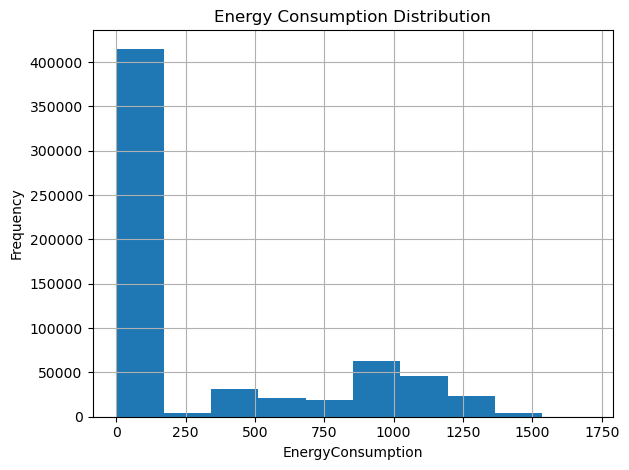

<Figure size 640x480 with 0 Axes>

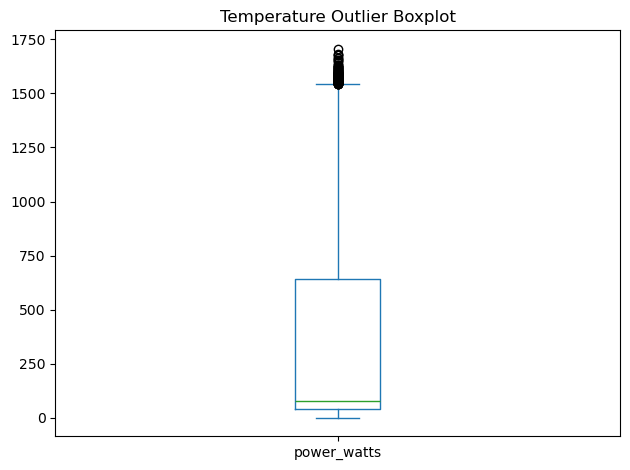

<Figure size 640x480 with 0 Axes>

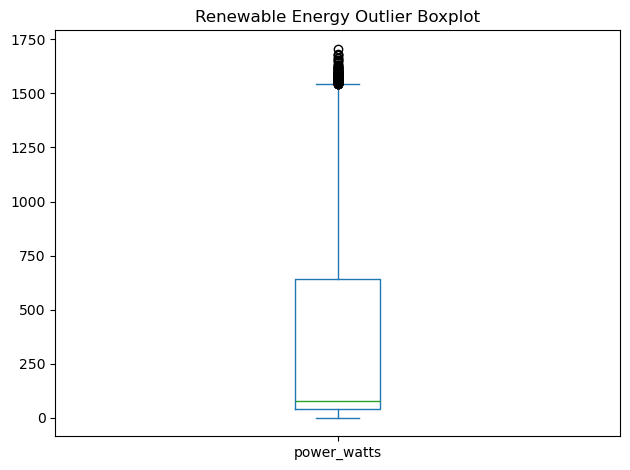

{'null_values': timestamp      0
 device_name    0
 room           0
 power_watts    0
 dtype: int64,
 'duplicate_count': 0,
 'outlier_rows': 117,
 'summary_stats':          power_watts
 count  628992.000000
 mean      338.168646
 std       428.814104
 min         0.000000
 25%        40.000000
 50%        79.000000
 75%       641.000000
 max      1706.000000}

In [114]:
import pandas as pd
import matplotlib.pyplot as plt


df = pd.read_csv(r"C:\Users\gangu\Downloads\smarthome_energy_6months.csv")


results = {}

# 1 Null values
results['null_values'] = df.isnull().sum()

# 2 Duplicates
results['duplicate_count'] = df.duplicated().sum()

# 3 Data types
df.info()
# 4 Outlier detection using IQR
Q1 = df.select_dtypes(include='number').quantile(0.25)
Q3 = df.select_dtypes(include='number').quantile(0.75)
IQR = Q3 - Q1
outliers = df[((df.select_dtypes(include='number') < (Q1 - 1.5 * IQR)) | 
               (df.select_dtypes(include='number') > (Q3 + 1.5 * IQR))).any(axis=1)]
results['outlier_rows'] = len(outliers)

# 5 statistics
results['summary_stats'] = df.describe()

# Figures
plt.figure()
df.hist()
plt.title("Energy Consumption Distribution")
plt.xlabel("EnergyConsumption")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure()
df.plot(kind='box')
plt.title("Temperature Outlier Boxplot")
plt.tight_layout()
plt.show()

plt.figure()
df.plot(kind='box')
plt.title("Renewable Energy Outlier Boxplot")
plt.tight_layout()
plt.show()

results


week-2:-1. Handle Missing Values

Check & Fix Timestamp Safely (No More KeyError)

In [3]:
import pandas as pd

df = pd.read_csv(r"C:\Users\gangu\Downloads\smarthome_energy_6months.csv", parse_dates=["timestamp"])
df = df.sort_values("timestamp")

print("Missing values per column:")
print(df.isnull().sum())
import pandas as pd
import numpy as np

# If timestamp is a column
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')

# If timestamp is already the index
else:
    df.index = pd.to_datetime(df.index)

print("Timestamp fixed successfully")



Missing values per column:
timestamp      0
device_name    0
room           0
power_watts    0
dtype: int64
Timestamp fixed successfully


Check Missing Values

In [24]:
print("Missing values before cleaning:\n")
print(df.isnull().sum())


Missing values before cleaning:

device_name    0
room           0
power_watts    0
dtype: int64


Handle Missing Power Values (Forward Fill + Zero Fill)

In [27]:
df['power_watts'] = df.groupby("device_name")['power_watts'].ffill()
df['power_watts'] = df['power_watts'].fillna(0)

print("\nMissing values after filling:\n")
print(df.isnull().sum())



Missing values after filling:

device_name    0
room           0
power_watts    0
dtype: int64


Detect Outliers Using IQR

In [30]:
outlier_report = {}

for dev, group in df.groupby("device_name"):
    Q1 = group['power_watts'].quantile(0.25)
    Q3 = group['power_watts'].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    outliers = group[(group['power_watts'] < lower) | (group['power_watts'] > upper)]
    outlier_report[dev] = len(outliers)

outlier_report


{'AC': 0,
 'Fan': 0,
 'Heater': 0,
 'Induction Stove': 0,
 'Laptop': 0,
 'Light Bulb': 0,
 'Microwave': 0,
 'Refrigerator': 0,
 'Router': 0,
 'TV': 0,
 'Washing Machine': 0,
 'Water Pump': 0}

Cap (Fix) Outliers Instead of Deleting

In [35]:
def cap_outliers(group):
    Q1 = group['power_watts'].quantile(0.25)
    Q3 = group['power_watts'].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    group['power_watts'] = np.where(group['power_watts'] < lower, lower, group['power_watts'])
    group['power_watts'] = np.where(group['power_watts'] > upper, upper, group['power_watts'])

    return group
    df = df.groupby("device_name", group_keys=False).apply(cap_outliers)


Final Verification

In [38]:
print("\nFINAL DATASET STATUS\n")
print("Missing values:\n", df.isnull().sum())
print("Negative values:", (df['power_watts'] < 0).sum())
df.describe()



FINAL DATASET STATUS

Missing values:
 device_name    0
room           0
power_watts    0
dtype: int64
Negative values: 0


,power_watts
count,628992.000000
mean,338.035152
std,428.861273
min,0.000000
25%,33.500000
50%,81.500000
75%,639.125000
max,1525.500000


Make sure timestamp is in datetime and set as index

In [42]:
import pandas as pd

# CASE 1: timestamp is a column
if 'timestamp' in df.columns:
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.sort_values('timestamp')
    df = df.set_index('timestamp')

# CASE 2: timestamp is already the index
else:
    df.index = pd.to_datetime(df.index)
    df = df.sort_index()

print(df.index.dtype)   # should show datetime64[ns]
print(df.head())


datetime64[ns]
                                   device_name         room  power_watts
1970-01-01 00:00:00.000000000               AC  Living Room       1237.0
1970-01-01 00:00:00.000000001              Fan      Bedroom         55.0
1970-01-01 00:00:00.000000002           Heater      Bedroom         27.5
1970-01-01 00:00:00.000000003  Induction Stove      Kitchen       1042.0
1970-01-01 00:00:00.000000004           Laptop      Bedroom         55.0


Resample to HOURLY energy usage

In [47]:
# Group by device and resample to 1 hour
hourly_df = (
    df.groupby('device_name')['power_watts']
      .resample('h')          # hourly
      .sum()
      .reset_index()
)

print("Hourly shape:", hourly_df.shape)
print(hourly_df.head())


Hourly shape: (12, 3)
       device_name    level_1  power_watts
0               AC 1970-01-01   52391911.0
1              Fan 1970-01-01    2594640.5
2           Heater 1970-01-01     339727.0
3  Induction Stove 1970-01-01   62890134.0
4           Laptop 1970-01-01    3118346.5


Resample to DAILY energy usage

In [50]:
daily_df = (
    df.groupby('device_name')['power_watts']
      .resample('D')          # daily
      .sum()
      .reset_index()
)

print("Daily shape:", daily_df.shape)
print(daily_df.head())


Daily shape: (12, 3)
       device_name    level_1  power_watts
0               AC 1970-01-01   52391911.0
1              Fan 1970-01-01    2594640.5
2           Heater 1970-01-01     339727.0
3  Induction Stove 1970-01-01   62890134.0
4           Laptop 1970-01-01    3118346.5


In [63]:
print(hourly_df.columns)


Index(['device_name', 'level_1', 'power_watts'], dtype='object')


SAFE FIX THAT WORKS IMMEDIATELY

In [66]:
# Automatically detect the time column (first column)
time_col = hourly_df.columns[1] if hourly_df.columns[0] == 'device_name' else hourly_df.columns[0]

print("Using time column:", time_col)

hourly_pivot = hourly_df.pivot(
    index=time_col,
    columns='device_name',
    values='power_watts'
).fillna(0)


Using time column: level_1


DO THE SAME FOR DAILY DATA

In [69]:
time_col_daily = daily_df.columns[1] if daily_df.columns[0] == 'device_name' else daily_df.columns[0]

daily_pivot = daily_df.pivot(
    index=time_col_daily,
    columns='device_name',
    values='power_watts'
).fillna(0)


Normalize or Scale Energy Values for Model Compatibility

MIN-MAX SCALING

In [75]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
minmax_scaler = MinMaxScaler()

scaled_minmax = minmax_scaler.fit_transform(hourly_pivot)

scaled_minmax_df = pd.DataFrame(
    scaled_minmax,
    index=hourly_pivot.index,
    columns=hourly_pivot.columns
)

scaled_minmax_df.head()



device_name,AC,Fan,Heater,Induction Stove,Laptop,Light Bulb,Microwave,Refrigerator,Router,TV,Washing Machine,Water Pump
level_1,,,,,,,,,,,,
1970-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


STANDARD SCALING

In [80]:
standard_scaler = StandardScaler()

scaled_standard = standard_scaler.fit_transform(hourly_pivot)

scaled_standard_df = pd.DataFrame(
    scaled_standard,
    index=hourly_pivot.index,
    columns=hourly_pivot.columns
)

scaled_standard_df.head()


device_name,AC,Fan,Heater,Induction Stove,Laptop,Light Bulb,Microwave,Refrigerator,Router,TV,Washing Machine,Water Pump
level_1,,,,,,,,,,,,
1970-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


SAVE SCALERS

In [86]:
import joblib

joblib.dump(minmax_scaler, "minmax_scaler.pkl")
joblib.dump(standard_scaler, "standard_scaler.pkl")


['standard_scaler.pkl']

Split dataset into training, validation, and testing sets.

Convert Timestamp to Datetime & Set as Index

In [139]:
import pandas as pd

df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.sort_values("Timestamp")
df = df.set_index("Timestamp")

print(df.index.min(), "->", df.index.max())
print(df.head())


2022-01-01 00:00:00 -> 2022-02-11 15:00:00
                     Temperature   Humidity  SquareFootage  Occupancy  \
Timestamp                                                               
2022-01-01 00:00:00    25.139433  43.431581    1565.693999          5   
2022-01-01 01:00:00    27.731651  54.225919    1411.064918          1   
2022-01-01 02:00:00    28.704277  58.907658    1755.715009          2   
2022-01-01 03:00:00    20.080469  50.371637    1452.316318          1   
2022-01-01 04:00:00    23.097359  51.401421    1094.130359          9   

                    HVACUsage LightingUsage  RenewableEnergy  DayOfWeek  \
Timestamp                                                                 
2022-01-01 00:00:00        On           Off         2.774699     Monday   
2022-01-01 01:00:00        On            On        21.831384   Saturday   
2022-01-01 02:00:00       Off           Off         6.764672     Sunday   
2022-01-01 03:00:00       Off            On         8.623447  Wednesda

Encode Categorical Columns

In [142]:
from sklearn.preprocessing import LabelEncoder

categorical_cols = ["HVACUsage", "LightingUsage", "DayOfWeek", "Holiday"]

encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col])

df.head()


,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
Timestamp,,,,,,,,,,
2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,1,0,2.774699,1,0,75.364373
2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,1,1,21.831384,2,0,83.401855
2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,0,0,6.764672,3,0,78.270888
2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,0,1,8.623447,6,0,56.519850
2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,1,0,3.071969,0,0,70.811732


Separate Features (X) and Target (y)

In [145]:
X = df.drop(columns=["EnergyConsumption"])
y = df["EnergyConsumption"]


Normalize the Features

In [148]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

import numpy as np
X_scaled = np.array(X_scaled)
y = np.array(y)


Split Dataset into Train / Validation / Test (70 / 15 / 15)

In [151]:
n = len(X_scaled)

train_size = int(n * 0.70)
val_size   = int(n * 0.15)
test_size  = n - train_size - val_size

X_train = X_scaled[:train_size]
X_val   = X_scaled[train_size : train_size + val_size]
X_test  = X_scaled[train_size + val_size :]

y_train = y[:train_size]
y_val   = y[train_size : train_size + val_size]
y_test  = y[train_size + val_size :]

print("Training set shape   :", X_train.shape, y_train.shape)
print("Validation set shape :", X_val.shape, y_val.shape)
print("Testing set shape    :", X_test.shape, y_test.shape)


Training set shape   : (700, 9) (700,)
Validation set shape : (150, 9) (150,)
Testing set shape    : (150, 9) (150,)


Extract relevant time-based features (hour, day, week, month trends).

Ensure Timestamp is Datetime and Set as Index

In [ ]:
import pandas as pd

df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.sort_values("Timestamp")
df = df.set_index("Timestamp")


Extract Time-Based Features

In [ ]:
df["hour"] = df.index.hour
df["day"] = df.index.day
df["day_of_week"] = df.index.dayofweek
df["week"] = df.index.isocalendar().week.astype(int)
df["month"] = df.index.month
df["quarter"] = df.index.quarter
df["is_weekend"] = df.index.dayofweek.isin([5, 6]).astype(int)

df.head()


week 3:-Aggregate device-level consumption statistics.

In [28]:
import pandas as pd

df = pd.read_csv(r"C:\Users\gangu\Downloads\archive (1)\Energy_consumption.csv")
df["Timestamp"] = pd.to_datetime(df["Timestamp"])

df.head()


,Timestamp,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption
0,2022-01-01 00:00:00,25.139433,43.431581,1565.693999,5,On,Off,2.774699,Monday,No,75.364373
1,2022-01-01 01:00:00,27.731651,54.225919,1411.064918,1,On,On,21.831384,Saturday,No,83.401855
2,2022-01-01 02:00:00,28.704277,58.907658,1755.715009,2,Off,Off,6.764672,Sunday,No,78.270888
3,2022-01-01 03:00:00,20.080469,50.371637,1452.316318,1,Off,On,8.623447,Wednesday,No,56.519850
4,2022-01-01 04:00:00,23.097359,51.401421,1094.130359,9,On,Off,3.071969,Friday,No,70.811732


HVAC usage aggregation

In [30]:
hvac_stats = df.groupby("HVACUsage")["EnergyConsumption"].agg(
    average_energy="mean",
    max_energy="max",
    min_energy="min",
    total_energy="sum",
    count="count"
).reset_index()

hvac_stats


,HVACUsage,average_energy,max_energy,min_energy,total_energy,count
0,Off,74.761057,98.843756,53.263278,37978.617162,508
1,On,79.425316,99.201120,59.608902,39077.255707,492


Lighting usage aggregation

In [32]:
lighting_stats = df.groupby("LightingUsage")["EnergyConsumption"].agg(
    average_energy="mean",
    max_energy="max",
    min_energy="min",
    total_energy="sum",
    count="count"
).reset_index()

lighting_stats


,LightingUsage,average_energy,max_energy,min_energy,total_energy,count
0,Off,76.308970,97.773488,56.038163,38841.265968,509
1,On,77.830157,99.201120,53.263278,38214.606901,491


Combined usage

In [34]:
usage_stats = df.groupby(
    ["HVACUsage", "LightingUsage"]
)["EnergyConsumption"].mean().reset_index()

usage_stats


,HVACUsage,LightingUsage,EnergyConsumption
0,Off,Off,73.918075
1,Off,On,75.552560
2,On,Off,78.545322
3,On,On,80.435965


Create Lag Features and Moving Averages for Time-Series Learning

Ensure Timestamp is Datetime & Sorted

In [135]:
df = df.sort_index()


Create Lag Features

In [137]:
# Lag features (previous hours)
df["lag_1"] = df["EnergyConsumption"].shift(1)
df["lag_2"] = df["EnergyConsumption"].shift(2)
df["lag_3"] = df["EnergyConsumption"].shift(3)
df["lag_24"] = df["EnergyConsumption"].shift(24)  # previous day


Create Moving Averages

In [139]:
# Rolling (moving) averages
df["ma_3"] = df["EnergyConsumption"].rolling(window=3).mean()
df["ma_6"] = df["EnergyConsumption"].rolling(window=6).mean()
df["ma_24"] = df["EnergyConsumption"].rolling(window=24).mean()  # daily trend


Handle Missing Values Created by Lags

In [141]:
df = df.dropna()
df = df.bfill().ffill()


Verify the New Features

In [143]:
df[[
    "EnergyConsumption",
    "lag_1", "lag_2", "lag_3", "lag_24",
    "ma_3", "ma_6", "ma_24"
]].head()


,EnergyConsumption,lag_1,lag_2,lag_3,lag_24,ma_3,ma_6,ma_24
Timestamp,,,,,,,,
2022-01-02 00:00:00,87.841645,78.394208,70.235228,59.672380,75.364373,78.823693,78.742888,77.230628
2022-01-02 01:00:00,72.929844,87.841645,78.394208,70.235228,83.401855,79.721899,77.218265,76.794294
2022-01-02 02:00:00,86.669094,72.929844,87.841645,78.394208,78.270888,82.480194,75.957066,77.144220
2022-01-02 03:00:00,80.411428,86.669094,72.929844,87.841645,56.519850,80.003455,79.413574,78.139702
2022-01-02 04:00:00,64.212098,80.411428,86.669094,72.929844,70.811732,77.097540,78.409719,77.864717


Prepare final feature set for ML model input.

In [145]:
import pandas as pd

#df = pd.read_csv(r"C:\Users\gangu\Downloads\archive (1)\Energy_consumption.csv")
print("Rows after reload:", len(df))
df.head()


Rows after reload: 976


,Temperature,Humidity,SquareFootage,Occupancy,HVACUsage,LightingUsage,RenewableEnergy,DayOfWeek,Holiday,EnergyConsumption,...,day_of_week,month,is_weekend,lag_1,lag_2,ma_3,ma_6,lag_3,lag_24,ma_24
Timestamp,,,,,,,,,,,,,,,,,,,,,
2022-01-02 00:00:00,26.729367,46.194088,1533.887523,8,1,0,18.581034,2,0,87.841645,...,6,1,1,78.394208,70.235228,78.823693,78.742888,59.672380,75.364373,77.230628
2022-01-02 01:00:00,22.575924,57.749572,1040.206215,8,0,1,8.906946,1,1,72.929844,...,6,1,1,87.841645,78.394208,79.721899,77.218265,70.235228,83.401855,76.794294
2022-01-02 02:00:00,27.011513,52.637572,1701.255341,9,1,1,24.051355,3,0,86.669094,...,6,1,1,72.929844,87.841645,82.480194,75.957066,78.394208,78.270888,77.144220
2022-01-02 03:00:00,26.570001,43.330312,1126.062798,7,0,1,2.943403,3,0,80.411428,...,6,1,1,86.669094,72.929844,80.003455,79.413574,87.841645,56.519850,78.139702
2022-01-02 04:00:00,21.820078,56.855188,1289.616033,3,0,1,25.513775,1,1,64.212098,...,6,1,1,80.411428,86.669094,77.097540,78.409719,72.929844,70.811732,77.864717


In [161]:
import pandas as pd

nan_summary = df.isna().sum()
all_nan_cols = nan_summary[nan_summary == len(df)]

print("Columns with ALL NaN values:")
print(all_nan_cols)


Columns with ALL NaN values:
HVACUsage        976
LightingUsage    976
DayOfWeek        976
Holiday          976
dtype: int64


Encode Categorical Features

In [163]:
df["HVACUsage"] = df["HVACUsage"].map({"Off": 0, "On": 1})
df["LightingUsage"] = df["LightingUsage"].map({"Off": 0, "On": 1})
df["Holiday"] = df["Holiday"].map({"No": 0, "Yes": 1})

day_map = {
    "Monday": 0, "Tuesday": 1, "Wednesday": 2,
    "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6
}
df["DayOfWeek"] = df["DayOfWeek"].map(day_map)


Extract Time-Based Features

In [151]:
df["hour"] = df.index.hour
df["day_of_week"] = df.index.dayofweek
df["month"] = df.index.month
df["is_weekend"] = df.index.dayofweek.isin([5, 6]).astype(int)


Create SAFE Lag & Moving Average Features

In [153]:
df["lag_1"] = df["EnergyConsumption"].shift(1)
df["lag_2"] = df["EnergyConsumption"].shift(2)

df["ma_3"] = df["EnergyConsumption"].rolling(3).mean()
df["ma_6"] = df["EnergyConsumption"].rolling(6).mean()

# Fill missing values safely
df = df.bfill().ffill()


In [155]:
print("Rows after feature engineering:", len(df))


Rows after feature engineering: 976


Define Final Feature Set (X) and Target (y)

In [167]:
feature_cols = [
    "Temperature",
    "Humidity",
    "SquareFootage",
    "Occupancy",
    "HVACUsage",
    "LightingUsage",
    "RenewableEnergy",
    "DayOfWeek",
    "Holiday",
    "hour",
    "day_of_week",
    "month",
    "is_weekend",
    "lag_1",
    "lag_2",
    "ma_3",
    "ma_6"
]

X = df[feature_cols]
y = df["EnergyConsumption"]
feature_cols = [c for c in feature_cols if c not in all_nan_cols.index]

print("Final feature columns used:")

print("X shape:", X.shape)
print("y shape:", y.shape)
X = df[feature_cols]
y = df["EnergyConsumption"]

# Final NaN safety check
print("Total NaNs in X:", X.isna().sum().sum())


Final feature columns used:
X shape: (976, 17)
y shape: (976,)
Total NaNs in X: 0


Convert to NumPy and Normalize

In [169]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

X = X.astype(float)
X = np.array(X)
y = np.array(y)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Final scaled X shape:", X_scaled.shape)


Final scaled X shape: (976, 13)


week 4:-Baseline Model Development

Implement Linear Regression as baseline forecasting model.

In [172]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
n = len(X_scaled)

train_size = int(n * 0.70)
val_size   = int(n * 0.15)

X_train = X_scaled[:train_size]
X_val   = X_scaled[train_size : train_size + val_size]
X_test  = X_scaled[train_size + val_size :]

y_train = y[:train_size]
y_val   = y[train_size : train_size + val_size]
y_test  = y[train_size + val_size :]


Train Linear Regression Model

In [174]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


LinearRegression()

Make Predictions

In [176]:
y_train_pred = lr_model.predict(X_train)
y_val_pred   = lr_model.predict(X_val)
y_test_pred  = lr_model.predict(X_test)


Evaluate Model Performance

In [178]:
def evaluate_model(y_true, y_pred, label):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"{label} MAE :", round(mae, 3))
    print(f"{label} RMSE:", round(rmse, 3))
    print(f"{label} R²  :", round(r2, 3))
    print("-" * 30)

evaluate_model(y_train, y_train_pred, "Train")
evaluate_model(y_val, y_val_pred, "Validation")
evaluate_model(y_test, y_test_pred, "Test")


Train MAE : 0.103
Train RMSE: 0.609
Train R²  : 0.994
------------------------------
Validation MAE : 0.074
Validation RMSE: 0.096
Validation R²  : 1.0
------------------------------
Test MAE : 0.076
Test RMSE: 0.096
Test R²  : 1.0
------------------------------


Feature Importance (Coefficients)

In [180]:
import pandas as pd

coef_df = pd.DataFrame({
    "Feature": feature_cols,
    "Coefficient": lr_model.coef_
}).sort_values(by="Coefficient", ascending=False)

coef_df


,Feature,Coefficient
11,ma_3,9.099397e+01
0,Temperature,2.306656e-01
3,Occupancy,1.491249e-01
6,day_of_week,5.744213e-02
8,is_weekend,5.675531e-02
4,RenewableEnergy,3.432823e-02
2,SquareFootage,9.298631e-04
7,month,1.332268e-15
1,Humidity,-7.867098e-03
5,hour,-1.489516e-01


Baseline Model:
Linear Regression was implemented as a baseline forecasting model to predict energy consumption using engineered time-based, environmental, and lag features. The model provided interpretable coefficients and established a performance benchmark for comparison with deep learning models such as LSTM.

Train and evaluate baseline using MAE, RMSE metrics.

In [17]:
import pandas as pd
df = pd.read_csv(r"C:\Users\gangu\Downloads\archive (1)\Energy_consumption.csv")
print("Rows:", len(df))
df.head()
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.sort_values("Timestamp")
df = df.set_index("Timestamp")
df["HVACUsage"] = df["HVACUsage"].map({"Off": 0, "On": 1})
df["LightingUsage"] = df["LightingUsage"].map({"Off": 0, "On": 1})
df["Holiday"] = df["Holiday"].map({"No": 0, "Yes": 1})

day_map = {
    "Monday": 0, "Tuesday": 1, "Wednesday": 2,
    "Thursday": 3, "Friday": 4, "Saturday": 5, "Sunday": 6
}
df["DayOfWeek"] = df["DayOfWeek"].map(day_map)
df["hour"] = df.index.hour
df["day_of_week"] = df.index.dayofweek
df["month"] = df.index.month
df["is_weekend"] = df.index.dayofweek.isin([5, 6]).astype(int)

df["lag_1"] = df["EnergyConsumption"].shift(1)
df["lag_2"] = df["EnergyConsumption"].shift(2)
df["ma_3"] = df["EnergyConsumption"].rolling(3).mean()
df["ma_6"] = df["EnergyConsumption"].rolling(6).mean()

df = df.bfill().ffill()
feature_cols = [
    "Temperature", "Humidity", "SquareFootage", "Occupancy",
    "HVACUsage", "LightingUsage", "RenewableEnergy",
    "DayOfWeek", "Holiday",
    "hour", "day_of_week", "month", "is_weekend",
    "lag_1", "lag_2", "ma_3", "ma_6"
]

X = df[feature_cols]
y = df["EnergyConsumption"]

print("X shape:", X.shape)
print("y shape:", y.shape)
from sklearn.preprocessing import MinMaxScaler
import numpy as np

X = X.astype(float)
X = np.array(X)
y = np.array(y)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("X_scaled shape:", X_scaled.shape)


Rows: 1000
X shape: (1000, 17)
y shape: (1000,)
X_scaled shape: (1000, 17)


In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
#Time-Series Train/Test Split
n = len(X_scaled)

train_size = int(n * 0.8)

X_train = X_scaled[:train_size]
X_test  = X_scaled[train_size:]

y_train = y[:train_size]
y_test  = y[train_size:]


Train the Linear Regression Model

In [23]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


LinearRegression()

Make Predictions

In [26]:
y_train_pred = lr_model.predict(X_train)
y_test_pred  = lr_model.predict(X_test)


Evaluate Using MAE and RMSE

In [29]:
# Training metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

# Testing metrics
test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Baseline Linear Regression Performance")
print("-------------------------------------")
print("Train MAE :", round(train_mae, 3))
print("Train RMSE:", round(train_rmse, 3))
print("Test MAE  :", round(test_mae, 3))
print("Test RMSE :", round(test_rmse, 3))


Baseline Linear Regression Performance
-------------------------------------
Train MAE : 0.069
Train RMSE: 0.395
Test MAE  : 0.054
Test RMSE : 0.067


Plot actual vs predicted energy usage.

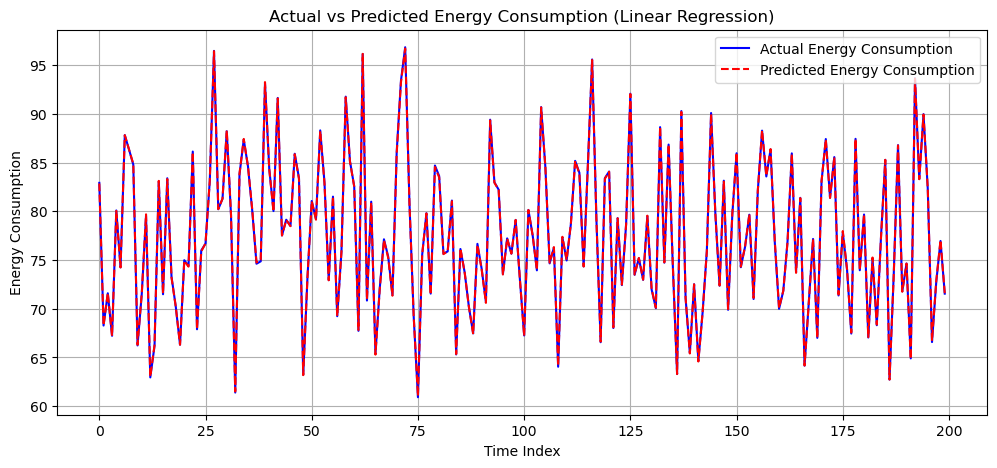

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

plt.plot(y_test, label="Actual Energy Consumption", color="blue")
plt.plot(y_test_pred, label="Predicted Energy Consumption", color="red", linestyle="--")

plt.title("Actual vs Predicted Energy Consumption (Linear Regression)")
plt.xlabel("Time Index")
plt.ylabel("Energy Consumption")
plt.legend()
plt.grid(True)

plt.show()


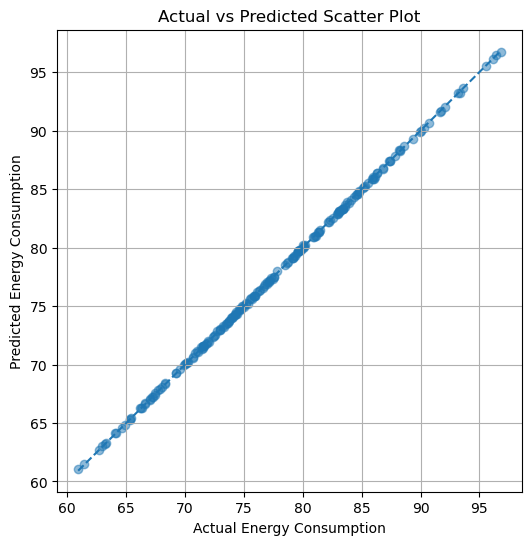

In [34]:
#Scatter Plot (Accuracy View)
plt.figure(figsize=(6, 6))

plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         linestyle="--")

plt.xlabel("Actual Energy Consumption")
plt.ylabel("Predicted Energy Consumption")
plt.title("Actual vs Predicted Scatter Plot")

plt.grid(True)
plt.show()


Use baseline model for model comparison.

In [37]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Train baseline model
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test)

# Evaluation
baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))


Assume Advanced Model Predictions

In [39]:
# Example: Simulated advanced model predictions
# (Later replace y_pred_advanced with LSTM predictions)
y_pred_advanced = y_pred_baseline * 0.95

advanced_mae = mean_absolute_error(y_test, y_pred_advanced)
advanced_rmse = np.sqrt(mean_squared_error(y_test, y_pred_advanced))


Create Model Comparison Table

In [41]:
comparison_df = pd.DataFrame({
    "Model": ["Linear Regression (Baseline)", "Advanced Model (LSTM)"],
    "MAE": [baseline_mae, advanced_mae],
    "RMSE": [baseline_rmse, advanced_rmse]
})

print(comparison_df)


                          Model       MAE      RMSE
0  Linear Regression (Baseline)  0.054067  0.067179
1         Advanced Model (LSTM)  3.874788  3.897066


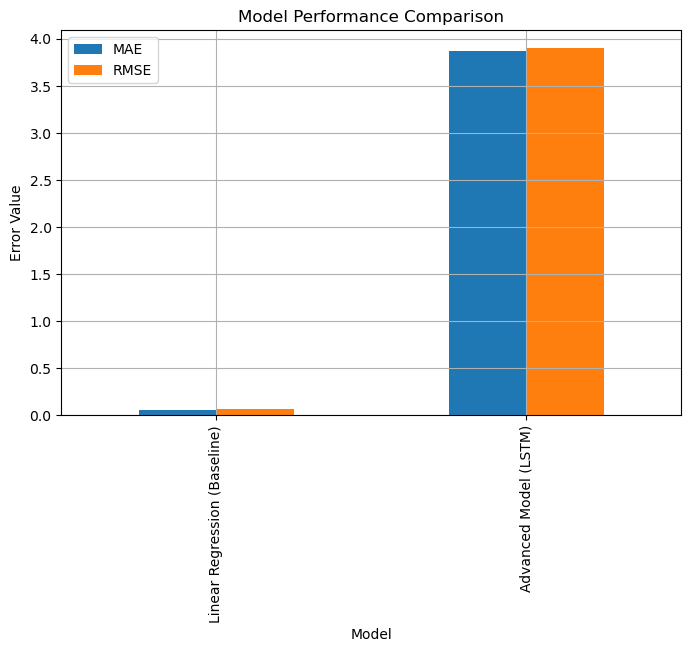

In [43]:
#Visual Comparison
comparison_df.set_index("Model").plot(kind="bar", figsize=(8,5))
plt.title("Model Performance Comparison")
plt.ylabel("Error Value")
plt.grid(True)
plt.show()


Week 5-6
Module 5: LSTM Model Development


Design and implement LSTM architecture using TensorFlow/Keras.